In [23]:
import os
import copy
import glob
import json

import numpy as np
import torch

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pgf import FigureCanvasPgf

mpl.backend_bases.register_backend("pdf", FigureCanvasPgf)
mpl.use("pgf")
%matplotlib inline
%config InlineBackend.figure_format="retina"

# Matplotlib plotting options
plt.style.use("seaborn-paper")
plt.rcParams.update({
    "axes.labelsize": 18,               # label size (x- and y-axis)
    "axes.titlesize": 22,               # title size on (most) axes
    "figure.titlesize": 22,             # title size for fig.sup_title()
    "legend.fontsize": "large",         # font size for legend
    "lines.markersize": 6,              # marker size for points and lines
    "lines.markeredgewidth": 2,         # marker edgewidth for points
    "xtick.labelsize": 14,              # label size for x-ticks 
    "ytick.labelsize": 14,              # label size for y-ticks

    "font.family": "serif",             # use serif/main font for text elements
    "text.usetex": True,                # use inline math for ticks
    "pgf.rcfonts": False,               # don't setup fonts from rc params
    "pgf.preamble": [
        # Syling
        r"\usepackage{color}",          # special colors
        r"\setmainfont{DejaVu Serif}",  # serif font via preamble

        # Math
        r"\usepackage{xfrac}",          # side fractions
        r"\usepackage{amsthm}",         # theorems
        r"\usepackage{amsmath}",        # misc math
        r"\usepackage{amssymb}",        # blackboard math symbols
        r"\usepackage{mathtools}",      # enhance the appearance of math
    ],
})

from profit.models.torch import SequenceOracle, SequenceGPR
from profit.utils.data_utils.tokenizers import AminoAcidTokenizer
from profit.utils.data_utils.serializers import LMDBSerializer

# Load dataset

In [2]:
def bbox_to_rect(bbox, color):
    # Convert to matplotlib format: ((upper-left x, upper-left y), width, height).
    return plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0],
                             height=bbox[3]-bbox[1], fill=False,
                             edgecolor=color, linewidth=2)

In [3]:
# Preprocess + load the dataset
dataset = LMDBSerializer.load("../../data/3gb1/processed/lstm_fitness/primary_encoding=aa20.mdb")
Xaa = dataset[:]["arr_0"].long()
_labels = dataset[:]["arr_1"].view(-1)

# Determine vocab and sequence length
tokenizer = AminoAcidTokenizer("aa20")
vocab_size = tokenizer.vocab_size
seqlen = Xaa.size(1)

# Reconvert back to onehot
X = torch.zeros(*Xaa.size(), vocab_size)
X.scatter_(2, torch.unsqueeze(Xaa, 2), 1)
X.size()

torch.Size([570, 56, 20])

# Oracle Comparison

In [4]:
paths = sorted(glob.glob("../../bin/3gb1/oracle/*/E*"))
metadata = ["all", "all-weighted", "g-mean", "l-mean", "g-median", "l-median", "g-zero"]
oracle_paths = dict(zip(metadata, paths))
oracle_paths

{'all': '../../bin/3gb1/oracle/2020-Apr-17-15:34:33/E0019.pt',
 'all-weighted': '../../bin/3gb1/oracle/2020-Apr-17-15:34:55/E0001.pt',
 'g-mean': '../../bin/3gb1/oracle/2020-Apr-17-15:35:44/E0017.pt',
 'l-mean': '../../bin/3gb1/oracle/2020-Apr-17-15:36:07/E0012.pt',
 'g-median': '../../bin/3gb1/oracle/2020-Apr-17-15:36:30/E0002.pt',
 'l-median': '../../bin/3gb1/oracle/2020-Apr-17-15:55:29/E0017.pt',
 'g-zero': '../../bin/3gb1/oracle/2020-Apr-17-15:55:55/E0003.pt'}

In [5]:
# Initialize and load weights for all oracles
oracle_stump = SequenceOracle(seqlen, vocab_size, hidden_size=50, out_size=2)
all_oracles = {}
for desc, path in oracle_paths.items():
    oracle = copy.deepcopy(oracle_stump)
    oracle.load_state_dict(torch.load(path))
    all_oracles[desc] = oracle

# Evaluate on oracle to get predictions
preds = {}
for desc, oracle in all_oracles.items():
    oracle.eval()
    with torch.no_grad():
        oracle_pred = oracle(X)[:,0]
        preds[desc] = oracle_pred
        
# Print topk oracle (pred) values 
for desc, pred in preds.items():
    idx = torch.sort(pred).indices[-10:]
    print(desc.upper(), pred[idx], _labels[idx])

ALL tensor([0.2090, 0.2198, 0.2266, 0.2281, 0.2350, 0.2369, 0.2630, 0.2750, 0.2860,
        0.3285]) tensor([0.2456, 0.3696, 0.6578, 2.1406, 5.0733, 0.1637, 0.1523, 0.7183, 1.2266,
        3.6708])
ALL-WEIGHTED tensor([1.7207, 1.7350, 1.7428, 1.7429, 1.7437, 1.7442, 1.7521, 1.7558, 1.7585,
        1.7730]) tensor([0.1649, 0.1523, 5.0733, 2.4872, 3.1087, 1.6815, 2.1406, 1.2266, 0.6578,
        0.5601])
G-MEAN tensor([2.2184, 2.2205, 2.2241, 2.2251, 2.2288, 2.2340, 2.2461, 2.2752, 2.2832,
        2.2986]) tensor([5.8051e-03, 1.2266e+00, 2.4872e+00, 6.7013e-04, 0.0000e+00, 4.9163e+00,
        5.0733e+00, 3.6708e+00, 3.1087e+00, 1.8073e+00])
L-MEAN tensor([0.0697, 0.0697, 0.0703, 0.0730, 0.0734, 0.0799, 0.0821, 0.0847, 0.0860,
        0.1023]) tensor([5.0489e-03, 6.9097e-02, 6.0447e-02, 7.1761e-01, 1.1544e-03, 4.4566e-03,
        5.1031e-02, 1.7055e+00, 6.7646e-02, 6.6158e-02])
G-MEDIAN tensor([1.4875, 1.5006, 1.5120, 1.5161, 1.5194, 1.5205, 1.5224, 1.5233, 1.5298,
        1.5345]) tensor(

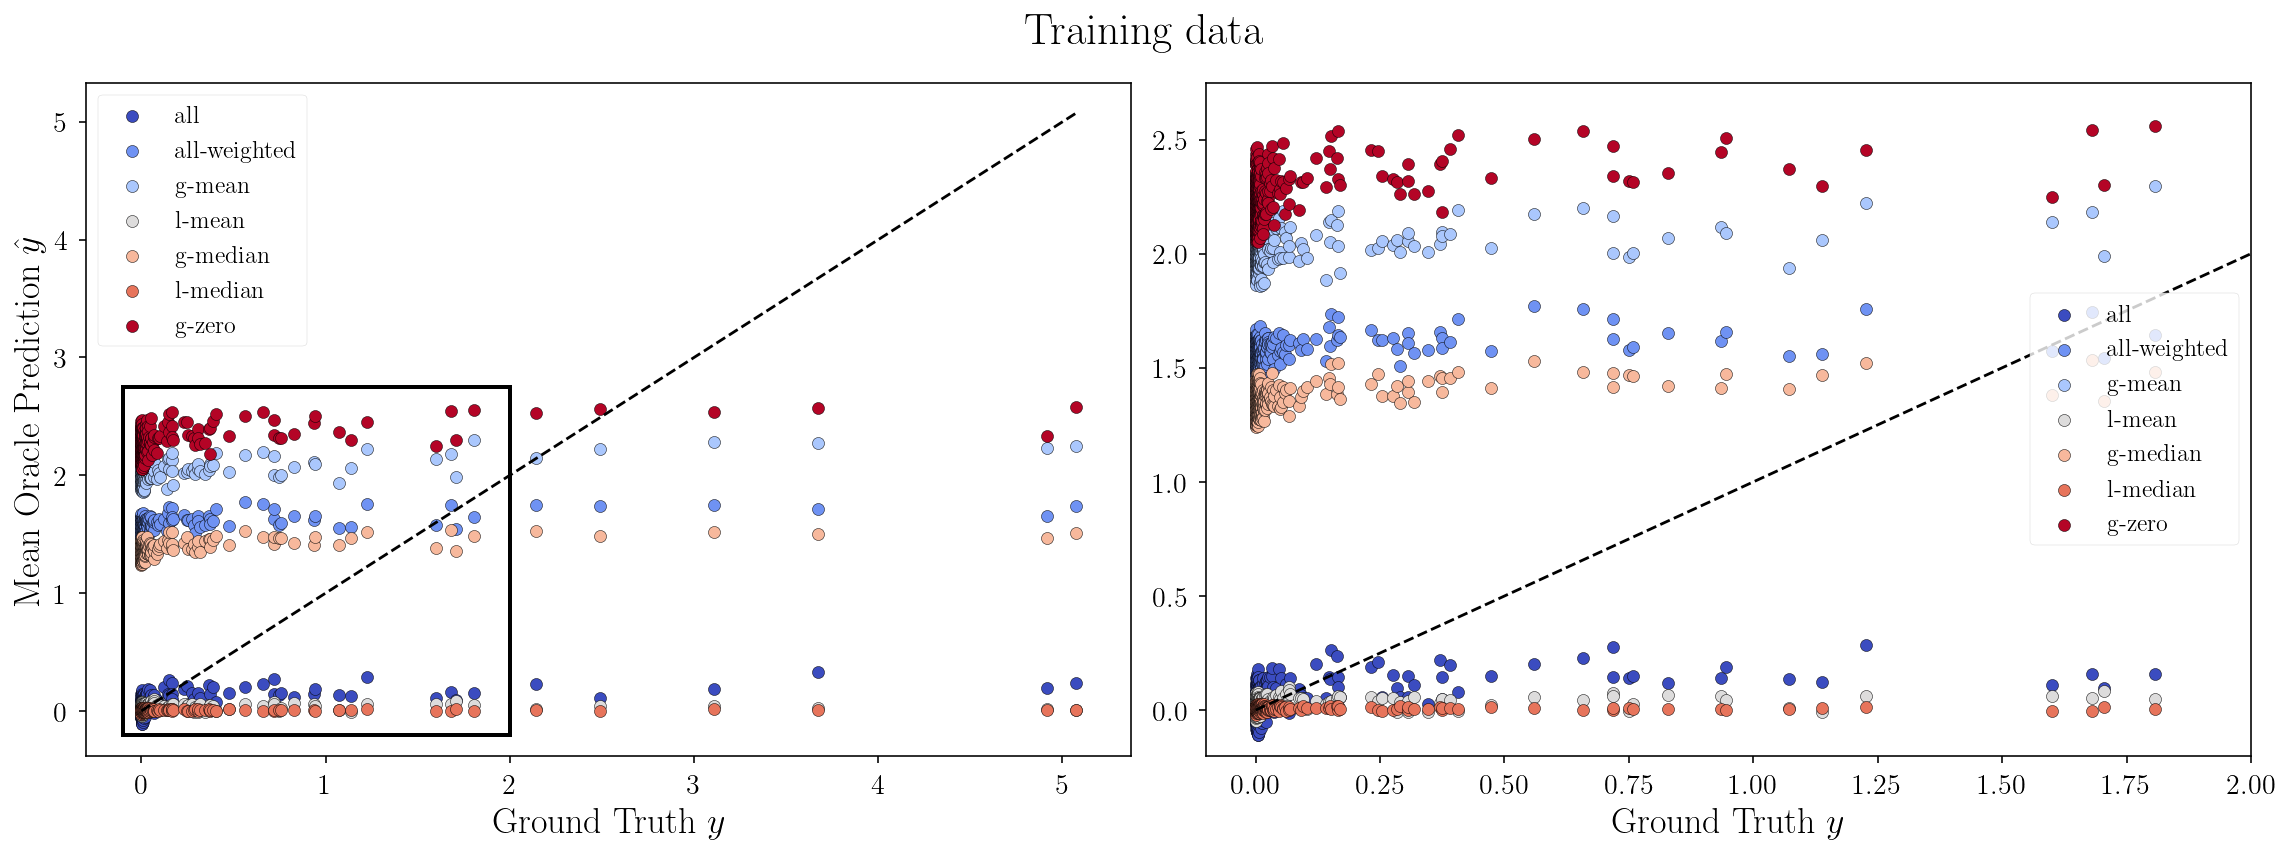

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
xy = np.linspace(_labels.min(), _labels.max()) # x = y
colors = cm.get_cmap("coolwarm")(np.linspace(0, 1, len(preds)))

# First graph
handles = []
for (desc, pred), c in zip(preds.items(), colors):
    h = ax1.scatter(_labels, pred, color=c, edgecolors="black", label=desc)
    handles.append(h)
ax1.plot(xy, xy, "--", c="black")
ax1.tick_params("both")
ax1.set_xlabel("Ground Truth $y$")
ax1.set_ylabel("Mean Oracle Prediction $\hat{y}$")
ax1.legend(handles, list(preds.keys()), scatterpoints=1)

# Add bounding box (view of 2nd graph)
bbox = np.array([-0.1, 2.75, 2, -0.2])
ax1.add_patch(bbox_to_rect(bbox, 'black'))

# Second graph
for (desc, pred), c in zip(preds.items(), colors):
    ax2.scatter(_labels, pred, color=c, edgecolors="black", label=desc)
ax2.plot(xy, xy, "--", c="black")
ax2.tick_params("both")
ax2.set_xlabel("Ground Truth $y$")
ax2.legend(handles, list(preds.keys()), scatterpoints=1)
ax2.set_xlim(bbox[[0,2]])
ax2.set_ylim(bbox[[1,-1]][::-1])

plt.tight_layout()
fig.suptitle("Training data")
plt.subplots_adjust(top=0.9)
plt.show()

# GPR Comparison

In [7]:
paths = sorted(glob.glob("../../bin/3gb1/gpr/*"))
metadata = ["all", "g-mean", "l-mean", "g-median", "l-median", "g-zero"]
gpr_paths = dict(zip(metadata, paths))
gpr_paths

{'all': '../../bin/3gb1/gpr/2020-Apr-17-16:14:58.pt',
 'g-mean': '../../bin/3gb1/gpr/2020-Apr-17-16:20:23.pt',
 'l-mean': '../../bin/3gb1/gpr/2020-Apr-17-16:20:58.pt',
 'g-median': '../../bin/3gb1/gpr/2020-Apr-17-16:21:36.pt',
 'l-median': '../../bin/3gb1/gpr/2020-Apr-17-16:21:53.pt',
 'g-zero': '../../bin/3gb1/gpr/2020-Apr-17-16:24:04.pt'}

In [8]:
# Initialize and load weights for all gprs
all_gps = {desc: torch.load(path) for desc, path in gpr_paths.items()}

# Evaluate on oracle to get predictions
preds = {}
for desc, gp in all_gps.items():
    y_mean = gp.predict(Xaa, return_std=False)
    preds[desc] = y_mean

# Print topk oracle (pred) values
for desc, pred in preds.items():
    pred = pred.squeeze() # flatten array
    idx = torch.sort(pred).indices[-10:]
    print(desc.upper(), pred[idx], _labels[idx])

ALL tensor([1.3298, 1.4522, 1.6066, 1.6298, 1.7879, 2.2132, 2.8175, 3.3207, 4.2519,
        4.4255]) tensor([1.6001, 1.7055, 1.6815, 1.8073, 2.1406, 2.4872, 3.1087, 3.6708, 5.0733,
        4.9163])
G-MEAN tensor([1.6737, 1.7365, 1.9096, 1.9164, 2.2615, 2.3424, 2.8968, 3.4578, 4.4004,
        4.5637]) tensor([0.0000, 1.8073, 2.1406, 0.0083, 0.0000, 2.4872, 3.1087, 3.6708, 5.0733,
        4.9163])
L-MEAN tensor([0.0418, 0.0446, 0.0465, 0.0469, 0.0495, 0.0506, 0.0550, 0.0596, 0.0609,
        0.0620]) tensor([0.0499, 0.0480, 0.0548, 0.0510, 0.0543, 0.0581, 0.0604, 0.0662, 0.0676,
        0.0691])
G-MEDIAN tensor([1.3748, 1.4642, 1.6239, 1.6440, 1.8706, 2.2366, 2.8245, 3.3361, 4.2904,
        4.4401]) tensor([1.6001, 1.7055, 1.6815, 1.8073, 2.1406, 2.4872, 3.1087, 3.6708, 5.0733,
        4.9163])
L-MEDIAN tensor([0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0029, 0.0031, 0.0031, 0.0032,
        0.0034]) tensor([0.0031, 0.0031, 0.0030, 0.0046, 0.0030, 0.0075, 0.0060, 0.0039, 0.0499,
        0.0

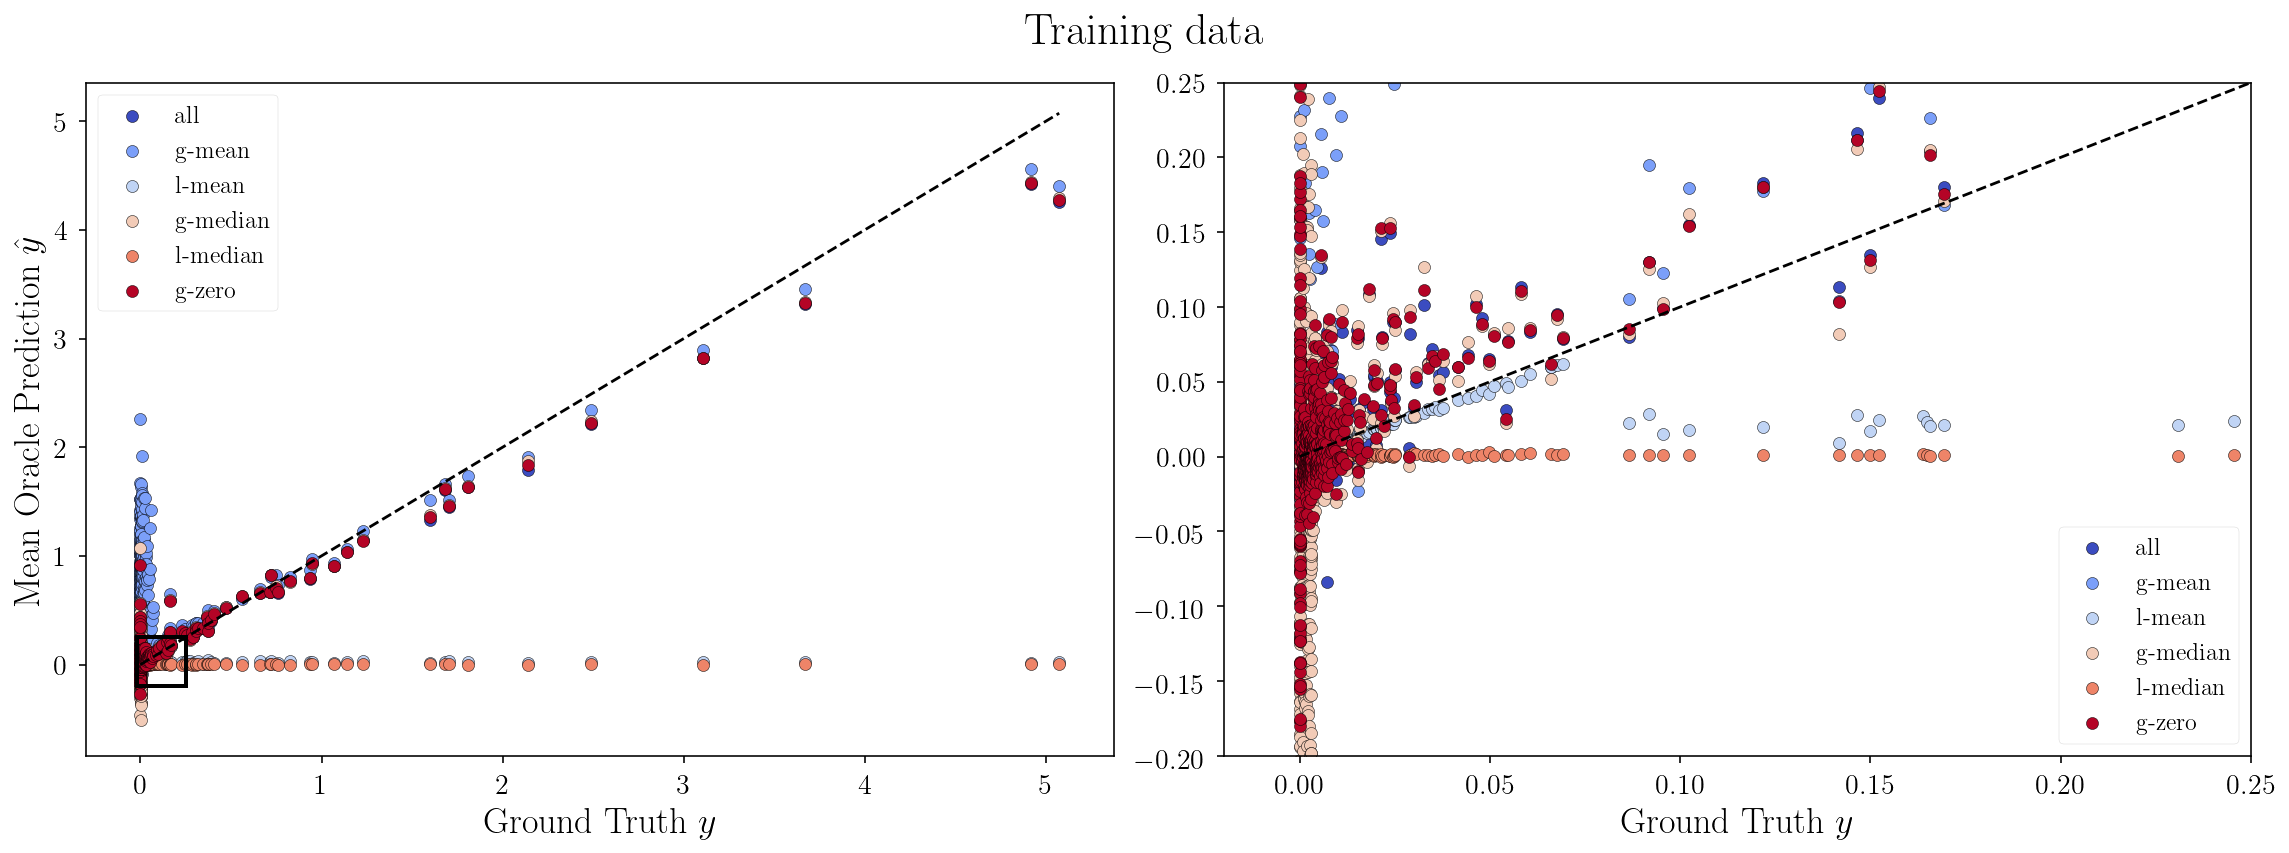

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
xy = np.linspace(_labels.min(), _labels.max()) # x = y
colors = cm.get_cmap("coolwarm")(np.linspace(0, 1, len(preds)))

# First graph
handles = []
for (desc, pred), c in zip(preds.items(), colors):
    h = ax1.scatter(_labels, pred, color=c, edgecolors="black", label=desc)
    handles.append(h)
ax1.plot(xy, xy, "--", c="black")
ax1.tick_params("both")
ax1.set_xlabel("Ground Truth $y$")
ax1.set_ylabel("Mean Oracle Prediction $\hat{y}$")
ax1.legend(handles, list(preds.keys()), scatterpoints=1)

# Add bounding box (zoomed in view of 2nd graph)
bbox = np.array([-0.02, 0.25, 0.25, -0.2])
ax1.add_patch(bbox_to_rect(bbox, 'black'))

# Second graph
for (desc, pred), c in zip(preds.items(), colors):
    ax2.scatter(_labels, pred, color=c, edgecolors="black", label=desc)
ax2.plot(xy, xy, "--", c="black")
ax2.tick_params("both")
ax2.set_xlabel("Ground Truth $y$")
ax2.legend(handles, list(preds.keys()), scatterpoints=1)
ax2.set_xlim(bbox[[0,2]])
ax2.set_ylim(bbox[[1,-1]][::-1])

plt.tight_layout()
fig.suptitle("Training data")
plt.subplots_adjust(top=0.9)
plt.show()

What we can see is that predictions are good, but often lower than GT. This might be because a lot of sequences in the original dataset is 0. Even if we train the kernel on the sequences that are greater than 0, the performance is still sub-par, at best.

# Condition by Adaptive Sampling (CbAS)

## Select optimal oracle/gp

We want to select the oracle and GT in such a fashion that (a) the oracle values are somewhat improving with each iteration and (b) the GT is not falling substantially with each iteration. Although not strictly required, it is important to select the oracle/GT s.t. the initial training dataset used to train both is about the same.

How do we handle this if the oracle is particularly bad at determining the fitness values between (good and bad) samples. This is currently happening since the oracle is the predicting the same values.

In [11]:
cbas_files = sorted(glob.glob("../../dumps/3gb1/cbas/*.json"))
cbas_files[:5]

['../../dumps/3gb1/cbas/oracle=all-weighted__gp=all.json',
 '../../dumps/3gb1/cbas/oracle=all-weighted__gp=g-mean.json',
 '../../dumps/3gb1/cbas/oracle=all-weighted__gp=g-median.json',
 '../../dumps/3gb1/cbas/oracle=all-weighted__gp=g-zero.json',
 '../../dumps/3gb1/cbas/oracle=all-weighted__gp=l-mean.json']

Text(0, 0.5, '$y_{\\mathrm{gt}}$')

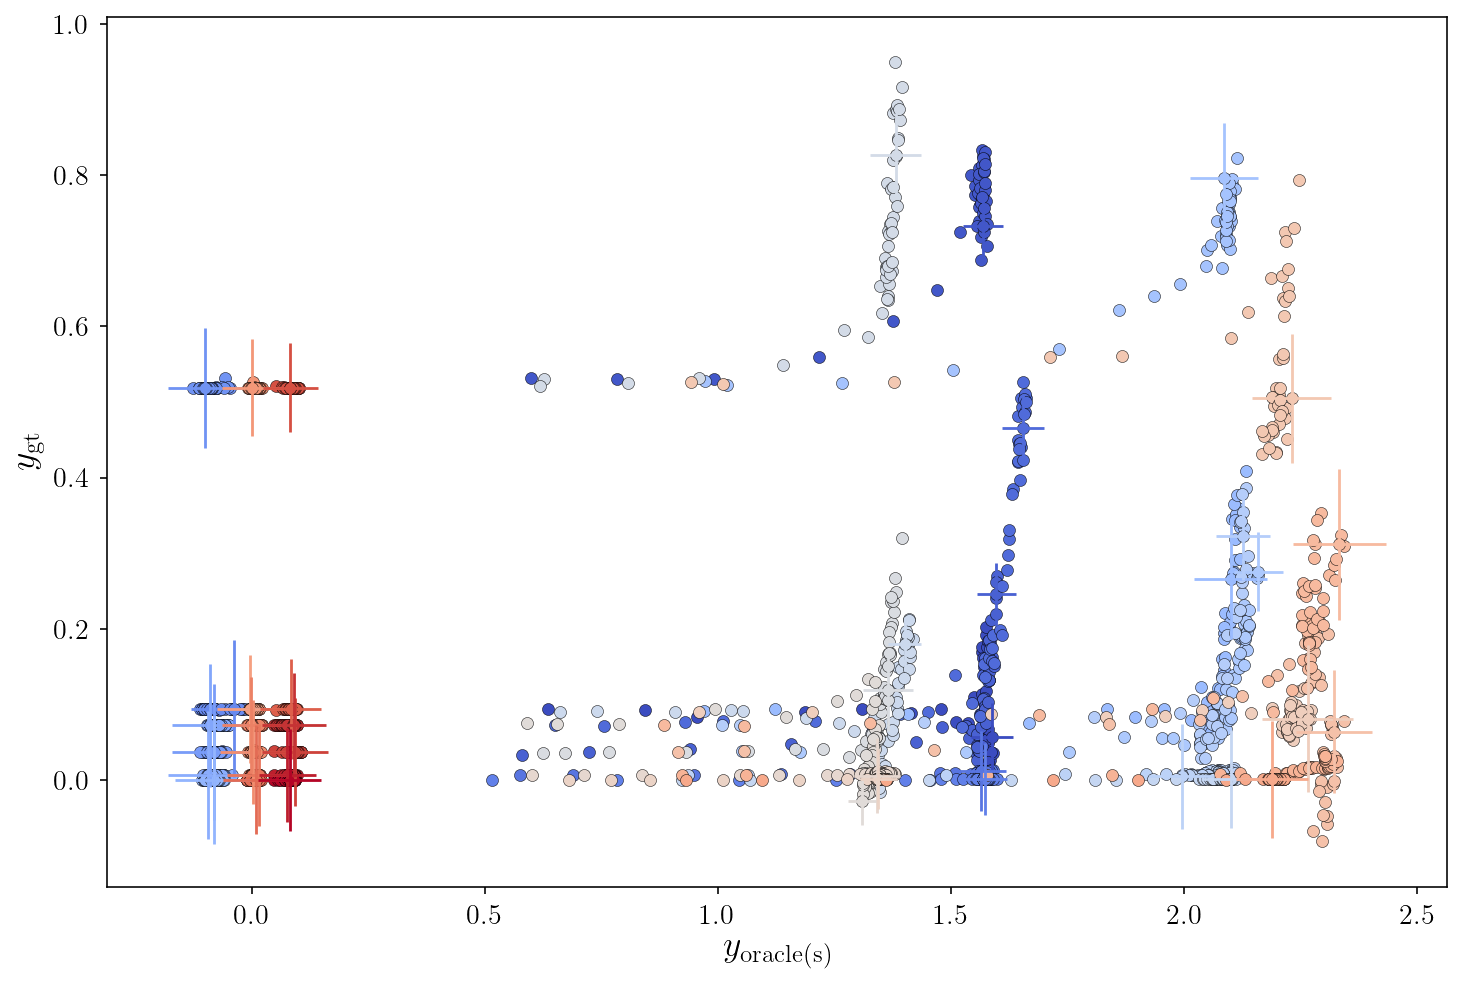

In [12]:
colors = cm.get_cmap("coolwarm")(np.linspace(0, 1, len(cbas_files)))
plt.figure(figsize=(12,8))

for file, c in zip(cbas_files, colors):
    with open(file, "rb") as json_file:
        values = json.load(json_file)
        # Compute mean and std of the samples for each experiment
        oracle_mean = np.mean(np.ma.masked_invalid(values["y_oracle"]), axis=-1)
        oracle_std = np.std(np.ma.masked_invalid(values["y_oracle"]), axis=-1)
        gt_mean = np.mean(np.ma.masked_invalid(values["y_gt"]), axis=-1)
        gt_std = np.mean(np.ma.masked_invalid(values["y_gt"]), axis=-1)
        # Plot results (error bars for last iteration)
        plt.scatter(oracle_mean, gt_mean, color=c, edgecolors="black")
        plt.errorbar(oracle_mean[-1], gt_mean[-1], xerr=oracle_std[-1], yerr=oracle_std[-1],
                     color=c, fmt='none')

plt.xlabel(r"$y_{\mathrm{oracle(s)}}$")
plt.ylabel(r"$y_{\mathrm{gt}}$")

Generally, we see that as number of iterations increase, both the GT and the oracle predictions (for the samples in that sequence) increases until the oracle reaches its asymptotic upper limit. This means that we have likely converge onto a decent sequence candidate set of sequences (within each iteration) which are not contained in the original dataset. Note that the GT values is largely ignored (still useful to determine if the model is not being led into "bad" sequence regions of the search space). 

We want to plot the trajectory of the top sequence (for both the oracle and the GT) across each of the 42 different runs. This will help us determine which is the "best" subset of the dataset to train the model(s) on. For instance, if the GT does not decrease substantially while the oracle is predicting high values that means the dataset is doing good.

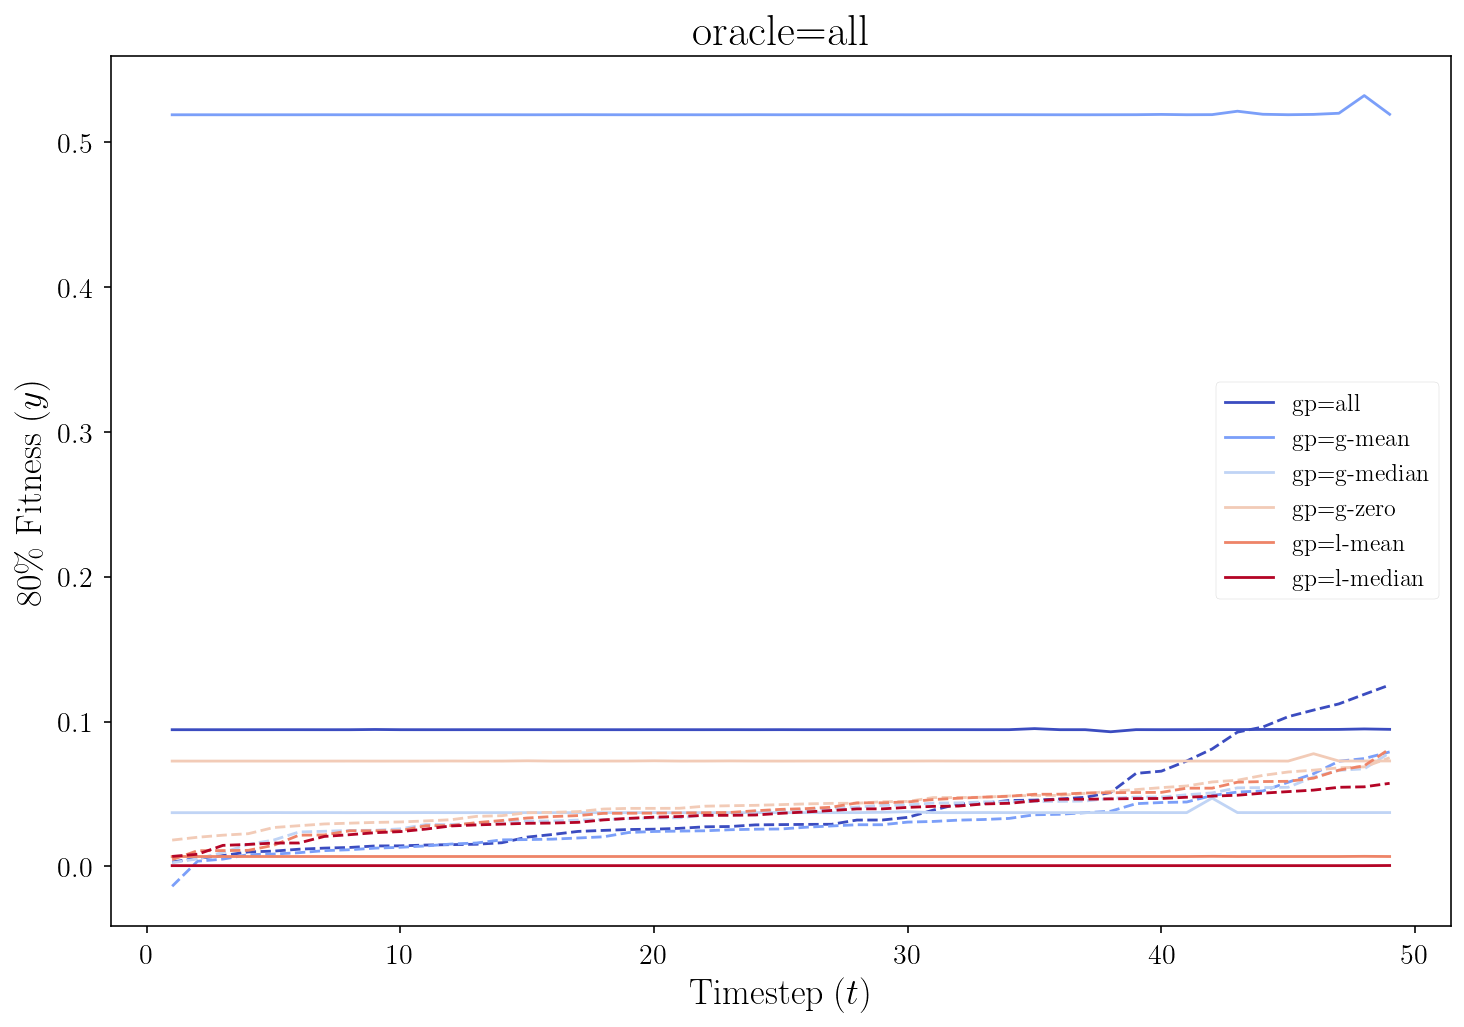

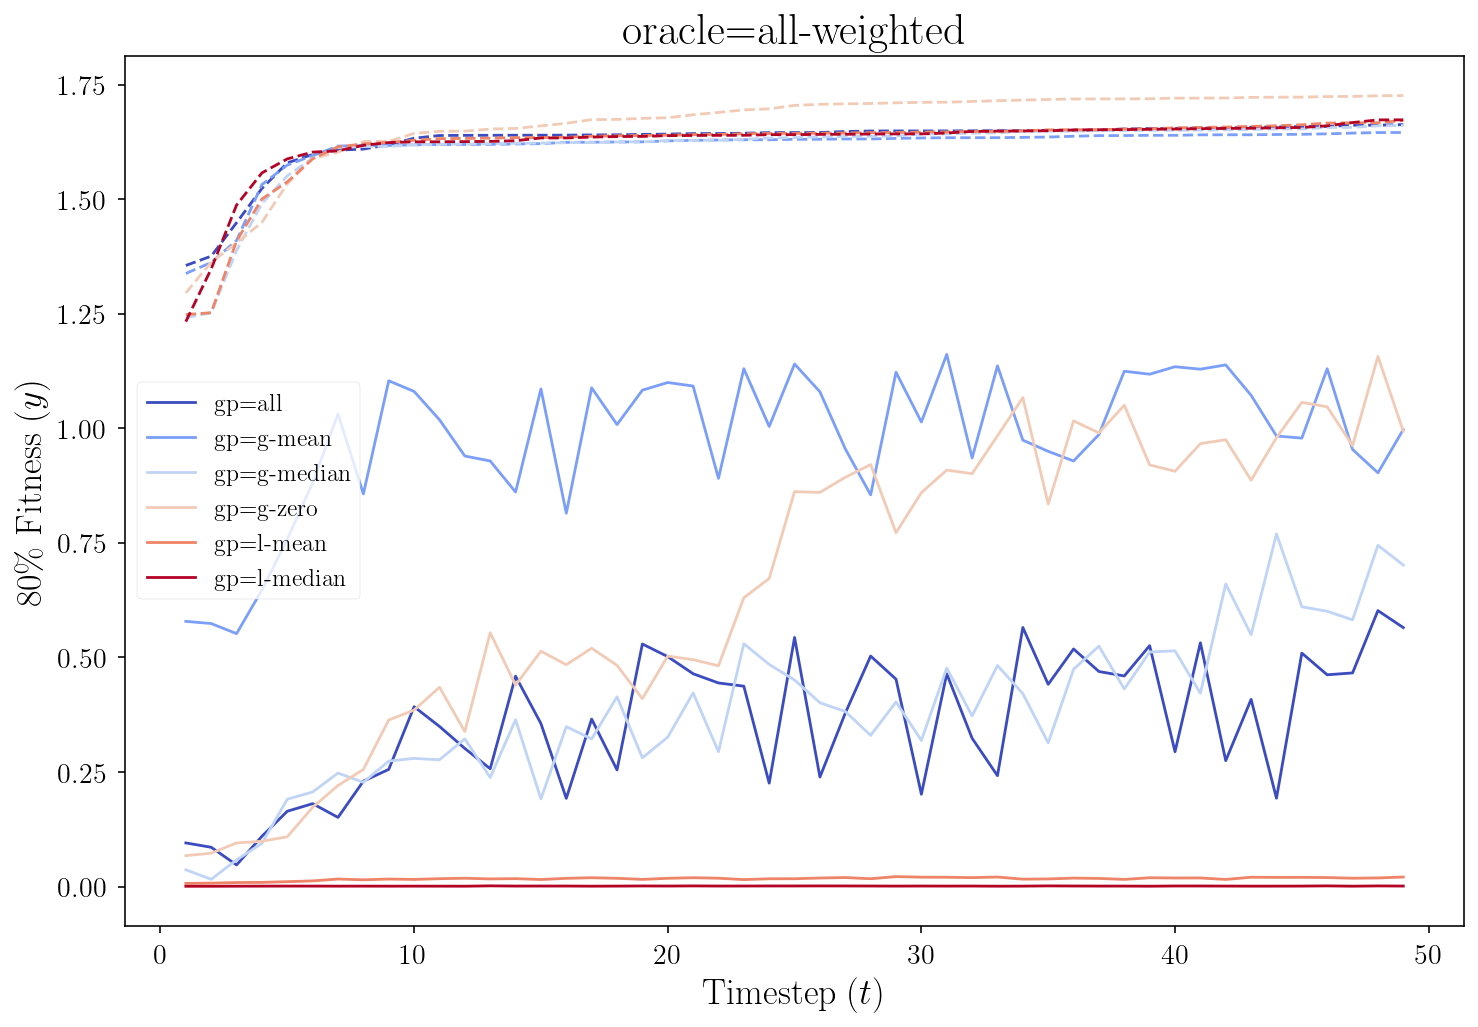

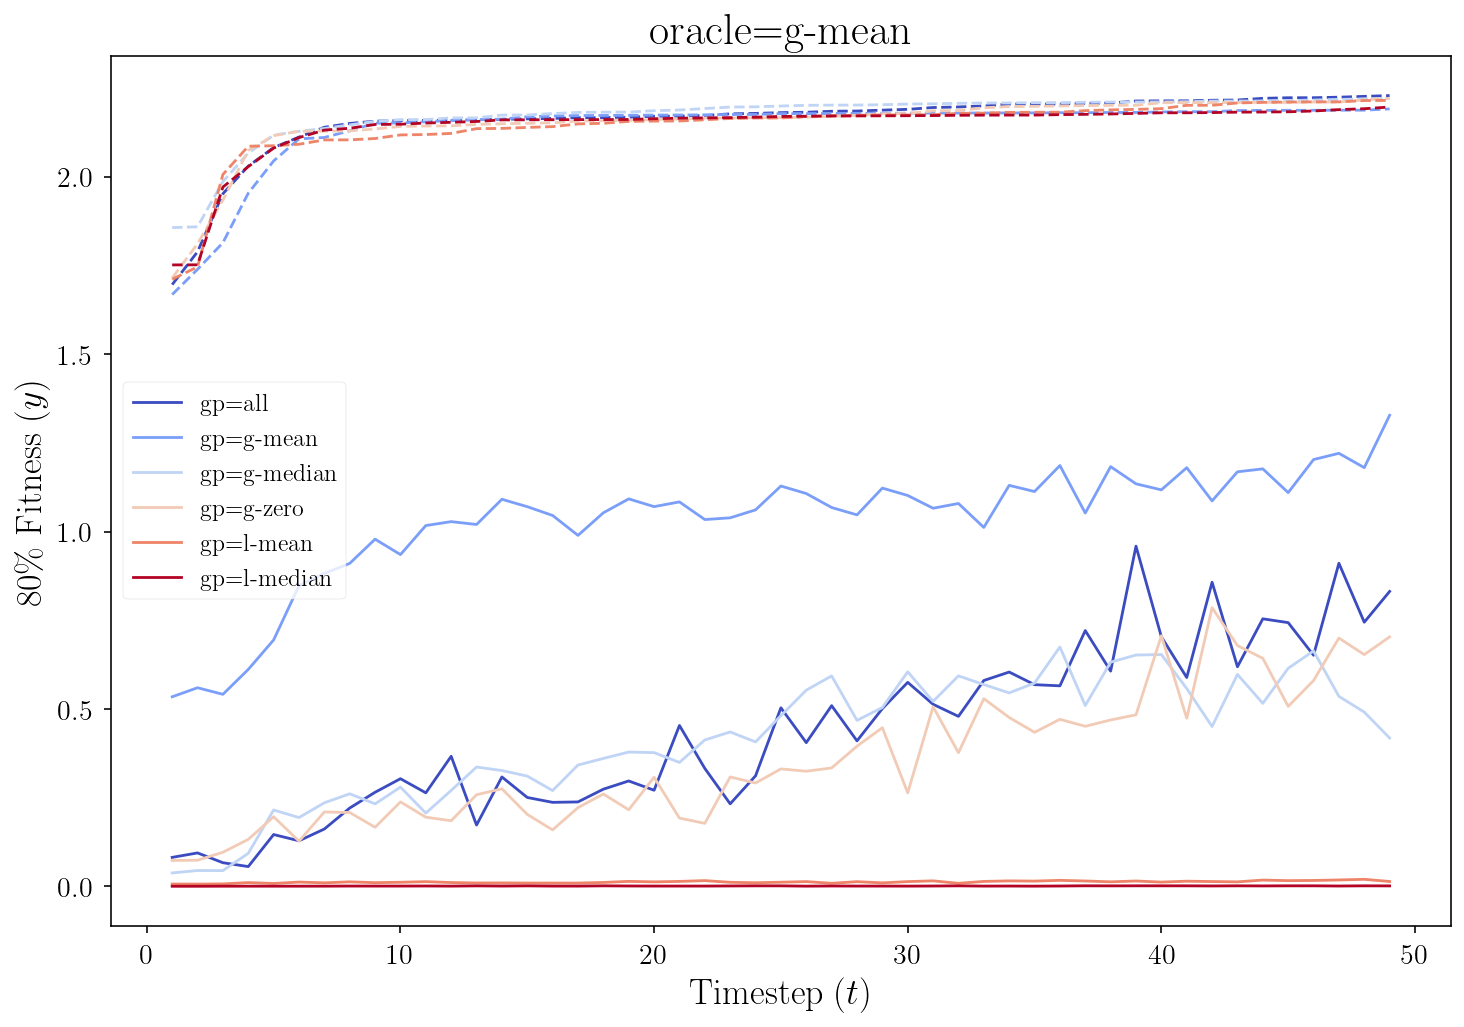

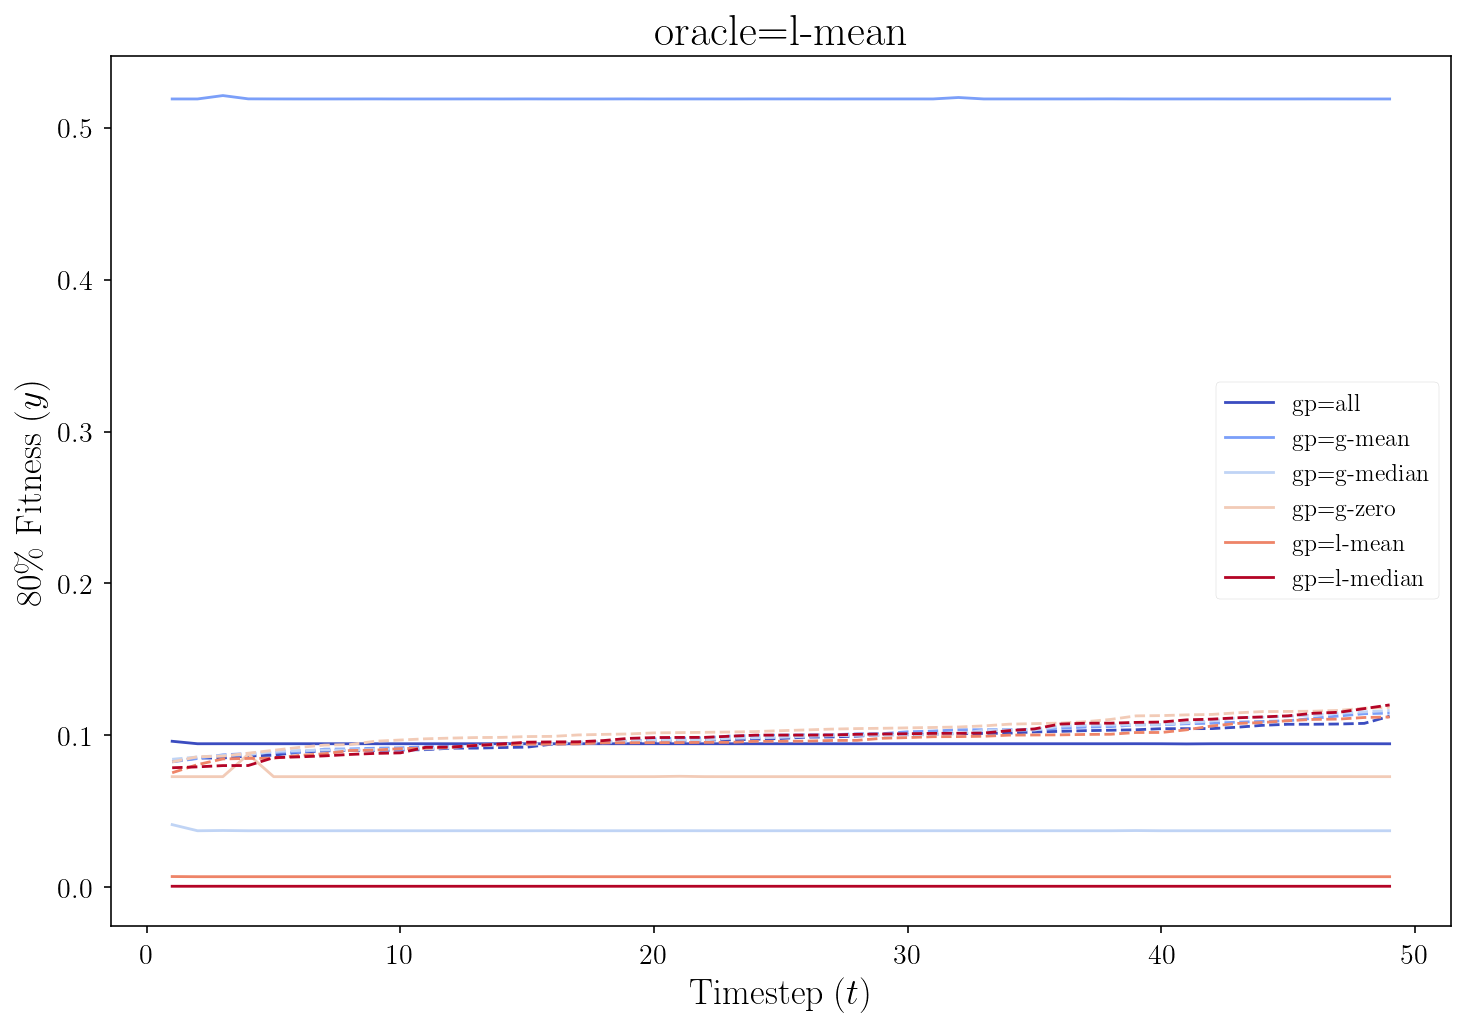

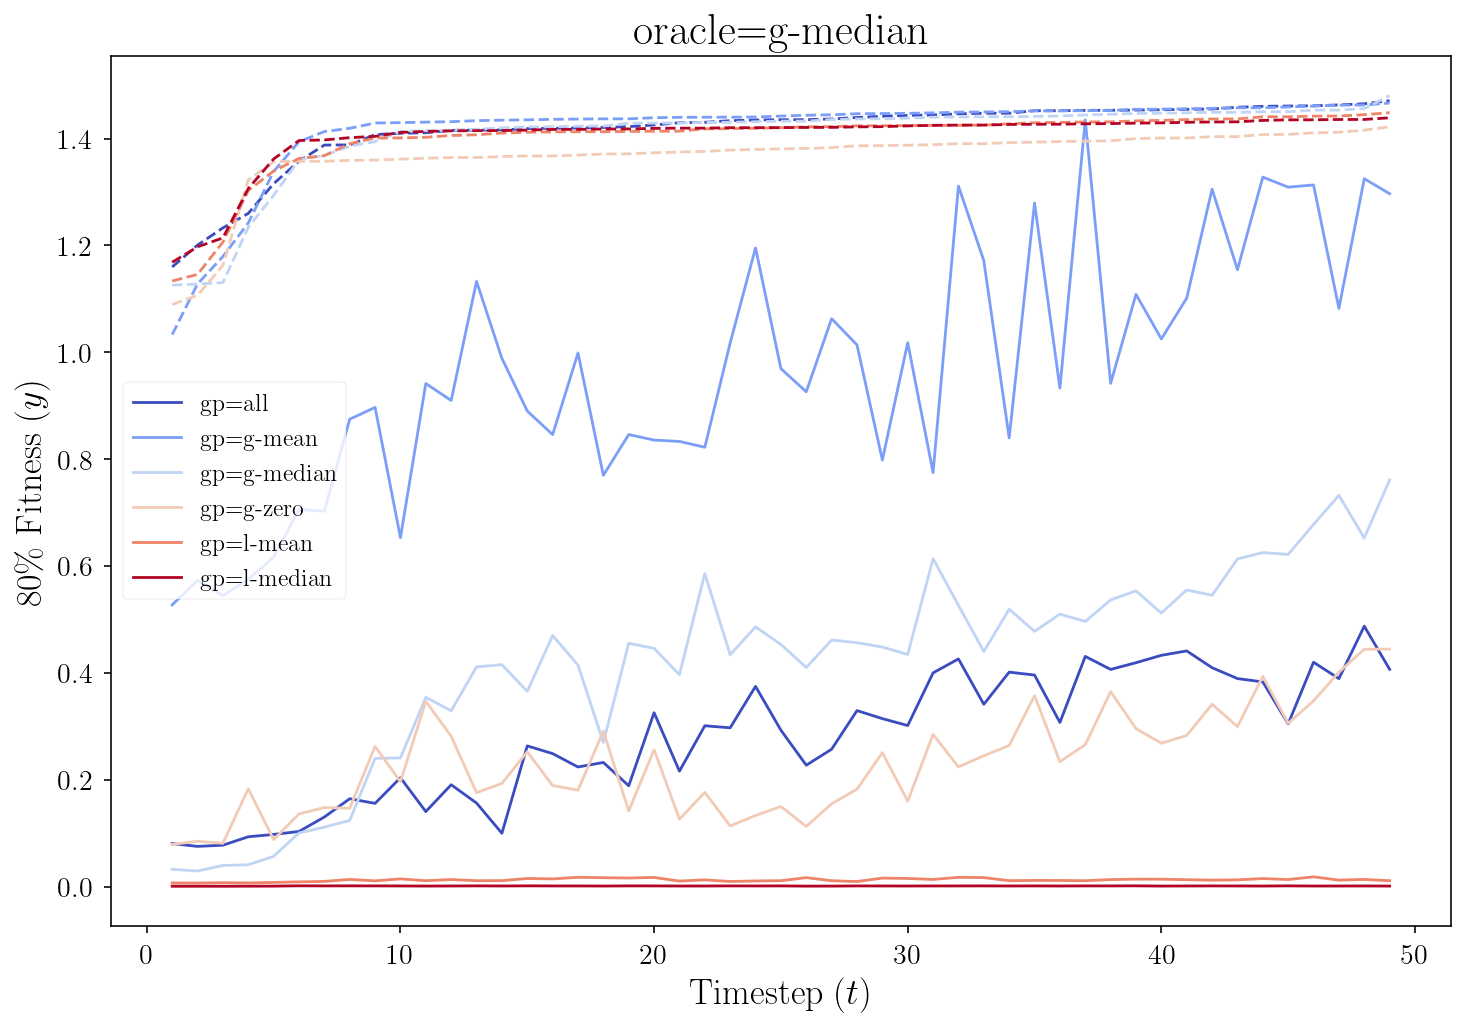

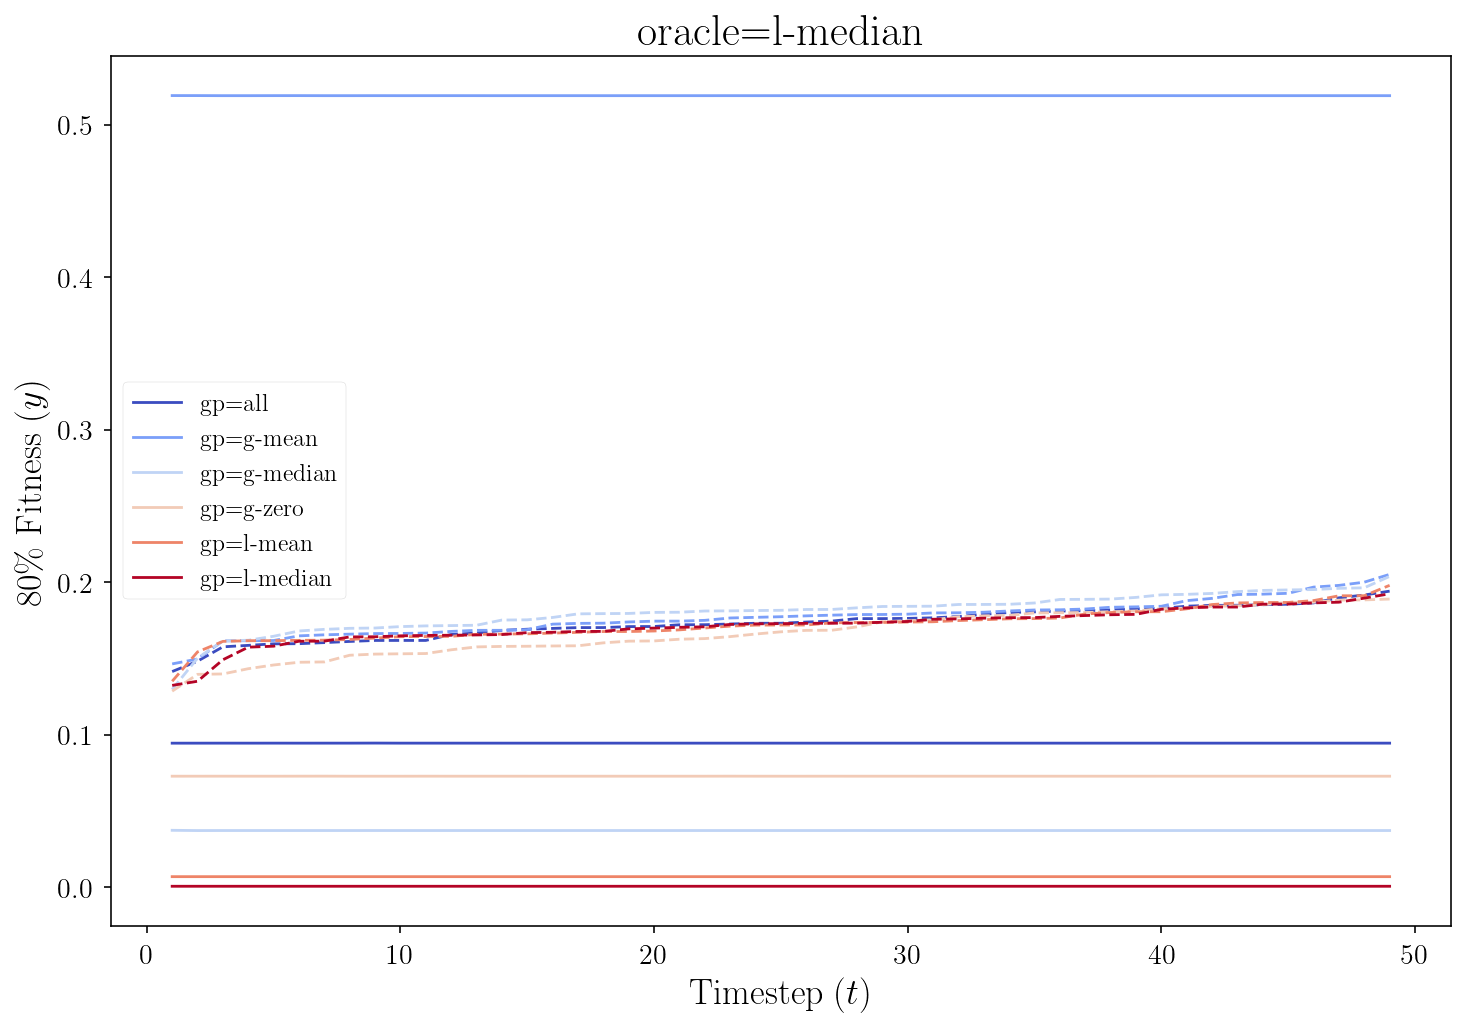

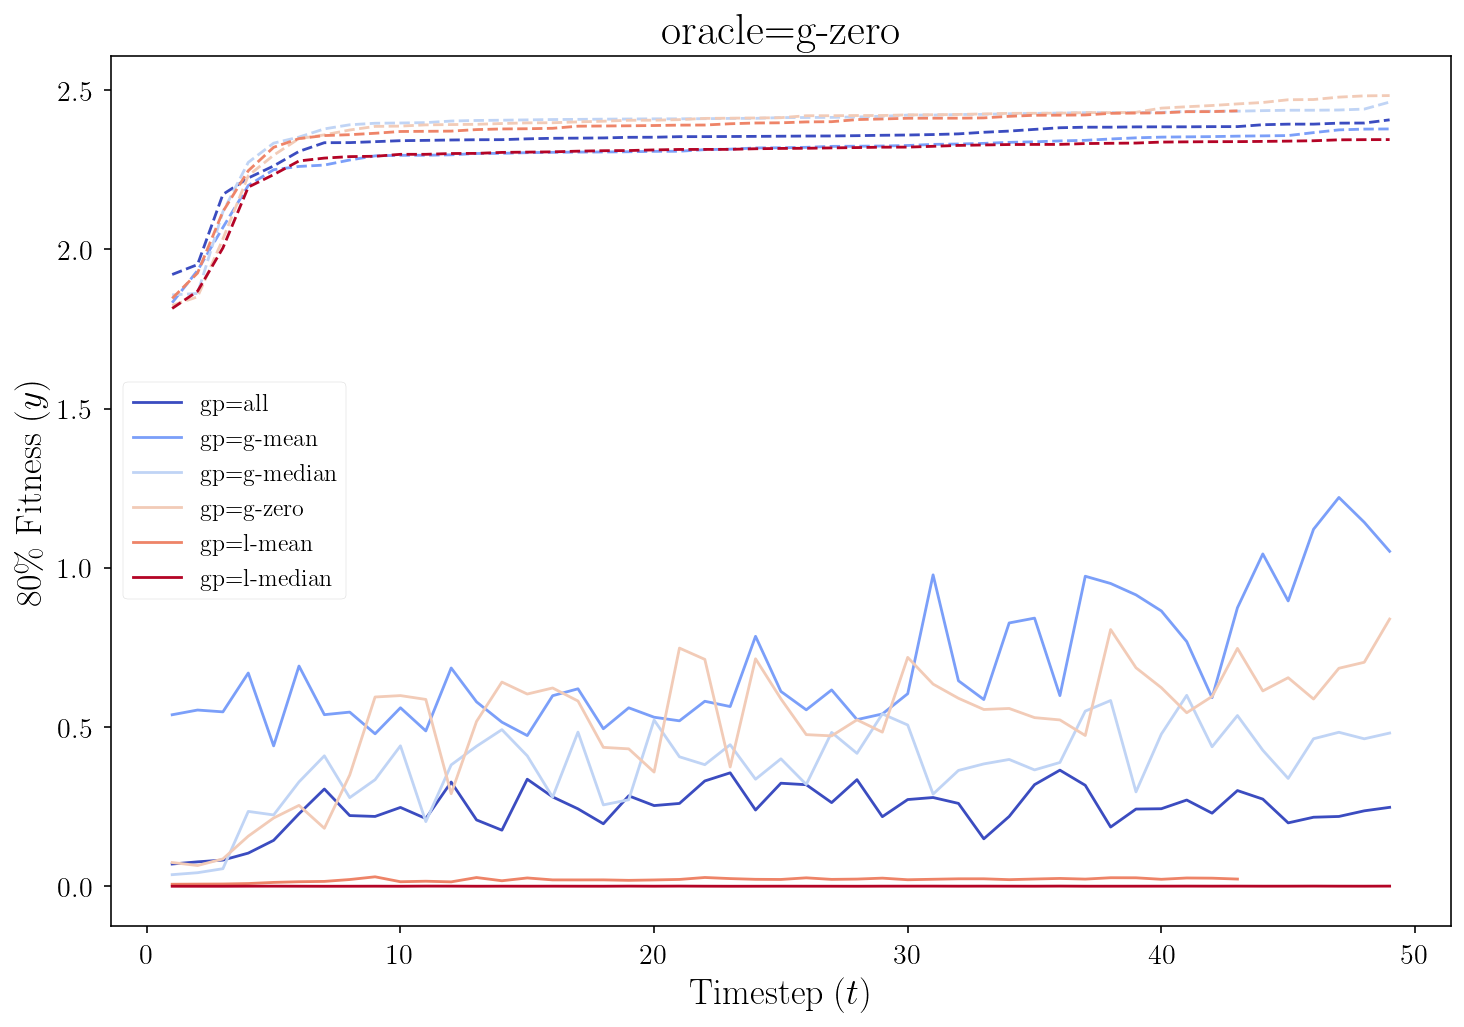

In [14]:
quantile = 0.80
sort = True

for oracle_key in oracle_paths.keys():
    # Gather values (for all GPs) for specified oracle
    plt.figure(figsize=(12,8))
    filepaths = [file for file in cbas_files if f"oracle={oracle_key}__" in file]
    gp_keys = [os.path.split(file)[-1].split(".")[0].split("__")[-1] for file in filepaths]
    colors = cm.get_cmap("coolwarm")(np.linspace(0, 1, len(filepaths)))
    for file, gp_key, c in zip(filepaths, gp_keys, colors):
        with open(file, "rb") as json_file:
            values = json.load(json_file)
        # Compute 80th percentile range for y_oracle
        oracle_samples = np.ma.masked_invalid(values["y_oracle"])
        per = np.percentile(oracle_samples, quantile*100, axis=-1)
        per = np.reshape(per, newshape=(oracle_samples.shape[0], 1))
        oracle_idxs = np.where(oracle_samples > per)
        
        # Average values for samples that are greater than quantile
        oracle_vals = np.zeros_like(oracle_samples)
        oracle_vals[oracle_idxs] = oracle_samples[oracle_idxs]
        oracle_vals = oracle_vals.sum(1) / (oracle_vals != 0).sum(1)
        
        gt_samples = np.ma.masked_invalid(values["y_gt"])
        gt_vals = np.zeros_like(gt_samples)
        gt_vals[oracle_idxs] = gt_samples[oracle_idxs]
        gt_vals = gt_vals.sum(1) / (gt_vals != 0).sum(1)
        
        # Sort oracle values (ascending) when plotting
        if sort:
            oracle_idxs = np.argsort(oracle_vals)
            oracle_vals = oracle_vals[oracle_idxs]
            gt_vals = gt_vals[oracle_idxs]
        
        # Plot values
        plt.plot(np.arange(1, len(oracle_vals)+1), oracle_vals, color=c, linestyle="dashed")
        plt.plot(np.arange(1, len(gt_vals)+1), gt_vals, color=c, label=gp_key)
    plt.xlabel("Timestep ($t$)")
    plt.ylabel(f"${quantile * 100:.0f}\%$ Fitness ($y$)")
    plt.title(f"oracle={oracle_key}")
    plt.legend()
    plt.show()

## Topk (k=10) sequences

In [15]:
# From the above experiments, it seems that no matter the oracle used,
# the GP where we select indicies greater than the mean, does not explore
# "uninteresting" regions of the sequence-space (as evidence by the fact
# that the GP remains at around the max value). As for the oracle, the best
# seems to be g-mean/g-median/g-zero as well (since they produce high GT values).
# Should we compare the topk sequences from each of these runs to see if they
# concur on similar sequences?

# NOTE that even though we do not report statistics on the above with the original
# data, we still train the VAE model at timestep 0 with the same 5000 random
# sequences generated.

with open("../../dumps/3gb1/cbas/oracle=g-mean__gp=g-mean.json", "rb") as json_file:
    results = json.load(json_file)

# What are the topk sequences and their predicted oracle/GT values
oracles = np.array(results["y_oracle"]).flatten()
topk_idx = np.argsort(oracles)[-10:]

seq_topk = np.array(results["seq"]).flatten()[topk_idx]
yt_topk = oracles[topk_idx]
yt_gt_topk = np.array(results["y_gt"]).flatten()[topk_idx]

print(yt_topk)
print(yt_gt_topk)
print(seq_topk)

[2.2608285  2.26124024 2.26129508 2.26188922 2.263412   2.26624298
 2.27156091 2.27882648 2.28198576 2.30062079]
[2.5723331  1.56457329 1.35173917 0.96995664 1.8256042  1.40203524
 1.1934669  1.3307023  1.83533025 1.42698431]
['MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQWAEWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSWREWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQWGEWTYDDATKTFTMTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIWGEWTYDDATKTFTVTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQHGEWTYDDATKTFTVTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQWGEWTYDDATKTFTVTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSHCEWTYDDATKTFTMTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSWCEWTYDDATKTFTVTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQWMEWTYDDATKTFTCTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSWMEWTYDDATKTFTCTE']


In [16]:
with open("../../dumps/3gb1/cbas/oracle=g-median__gp=g-mean.json", "rb") as json_file:
    results = json.load(json_file)

# What are the topk sequences and their predicted oracle/GT values
oracles = np.array(results["y_oracle"]).flatten()
topk_idx = np.argsort(oracles)[-10:]

seq_topk = np.array(results["seq"]).flatten()[topk_idx]
yt_topk = oracles[topk_idx]
yt_gt_topk = np.array(results["y_gt"]).flatten()[topk_idx]

print(yt_topk)
print(yt_gt_topk)
print(seq_topk)

[1.51794326 1.52096236 1.52098393 1.52116716 1.52193272 1.52455473
 1.52462912 1.52462912 1.52745283 1.52745283]
[ 0.74926686 -0.09591556  0.40577173  1.76790595  1.50167131  2.09452367
  0.51204348  0.51204348  0.40156412  0.40156412]
['MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAWAEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGMICEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAYCEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGHWGEWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGWYGEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAYGEWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAIGEWTYDDATKTFTGTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAIGEWTYDDATKTFTGTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAWGEWTYDDATKTFTTTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGAWGEWTYDDATKTFTTTE']


In [17]:
with open("../../dumps/3gb1/cbas/oracle=g-zero__gp=g-mean.json", "rb") as json_file:
    results = json.load(json_file)

# What are the topk sequences and their predicted oracle/GT values
oracles = np.array(results["y_oracle"]).flatten()
topk_idx = np.argsort(oracles)[-10:]

seq_topk = np.array(results["seq"]).flatten()[topk_idx]
yt_topk = oracles[topk_idx]
yt_gt_topk = np.array(results["y_gt"]).flatten()[topk_idx]

print(yt_topk)
print(yt_gt_topk)
print(seq_topk)

[2.50903273 2.50994754 2.52963352 2.53185821 2.53290987 2.53427744
 2.53625894 2.54033351 2.54363275 2.54579139]
[0.66505122 1.08065224 1.31846261 1.31186318 1.72883749 2.60042977
 2.32762671 1.41607952 1.84557629 1.61942315]
['MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIILEWTYDDATKTFTWTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGHYFEWTYDDATKTFTWTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGSYCEWTYDDATKTFTDTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQHCEWTYDDATKTFTDTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGQYCEWTYDDATKTFTDTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGEYAEWTYDDATKTFTATE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIYGEWTYDDATKTFTCTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIYGEWTYDDATKTFTDTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGIYGEWTYDDATKTFTGTE'
 'MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGHYGEWTYDDATKTFTDTE']


TODO: We now have to show that the sequences designed from the VAE are in fact better than random mutations, in terms of fitness. To do this, we take the topk sequences from the VAE, compute the number of mutations from the WT sequence (hamming distance) and plot its fitness values. Additionally, we sample some random mutations and plot their fitness scores. What we should see is that the designed sequences have a higher fitness score (on average) vs. the random mutations.

# Mutation heatmap

In [18]:
import pandas as pd
import seaborn as sns

from profit.dataset import generator
from profit.dataset.preprocessors import LSTMPreprocessor

In [19]:
positions = np.arange(20, 56)
num_mutation_sites = len(positions)
seqs = generator.gen(n=1)

In [46]:
# Permute each position with amino acid
preprocessor = LSTMPreprocessor(vocab="aa20")
all_seqs = []
for pos in positions:
    for seq in seqs:
        template = list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")
        template[pos-1] = seq
        all_seqs.append(preprocessor.get_input_feats(template))
all_seqs = torch.Tensor(all_seqs).long()

# Convert to onehot
S = torch.zeros(*all_seqs.size(), vocab_size)
S.scatter_(2, torch.unsqueeze(all_seqs, dim=2), 1)

# Evaluate on (g-mean) oracle to get predictions
gmean_oracle = all_oracle["g-mean"]
if isinstance(gmean_oracle, SequenceGPR):
    mean, sigma = gmean_oracle.predict(all_seqs, return_std=True)
    mean, sigma = torch.Tensor(mean).squeeze(), torch.Tensor(sigma).squeeze()
else:
    gmean_oracle.eval()
    with torch.no_grad():
        y_pred = gmean_oracle(S)
        mean, sigma = y_pred[:,0], torch.sqrt(y_pred[:,1])

NameError: name 'all_oracle' is not defined

Text(0.5, 1.0, 'Protein fitness (PDB: 3GB1)')

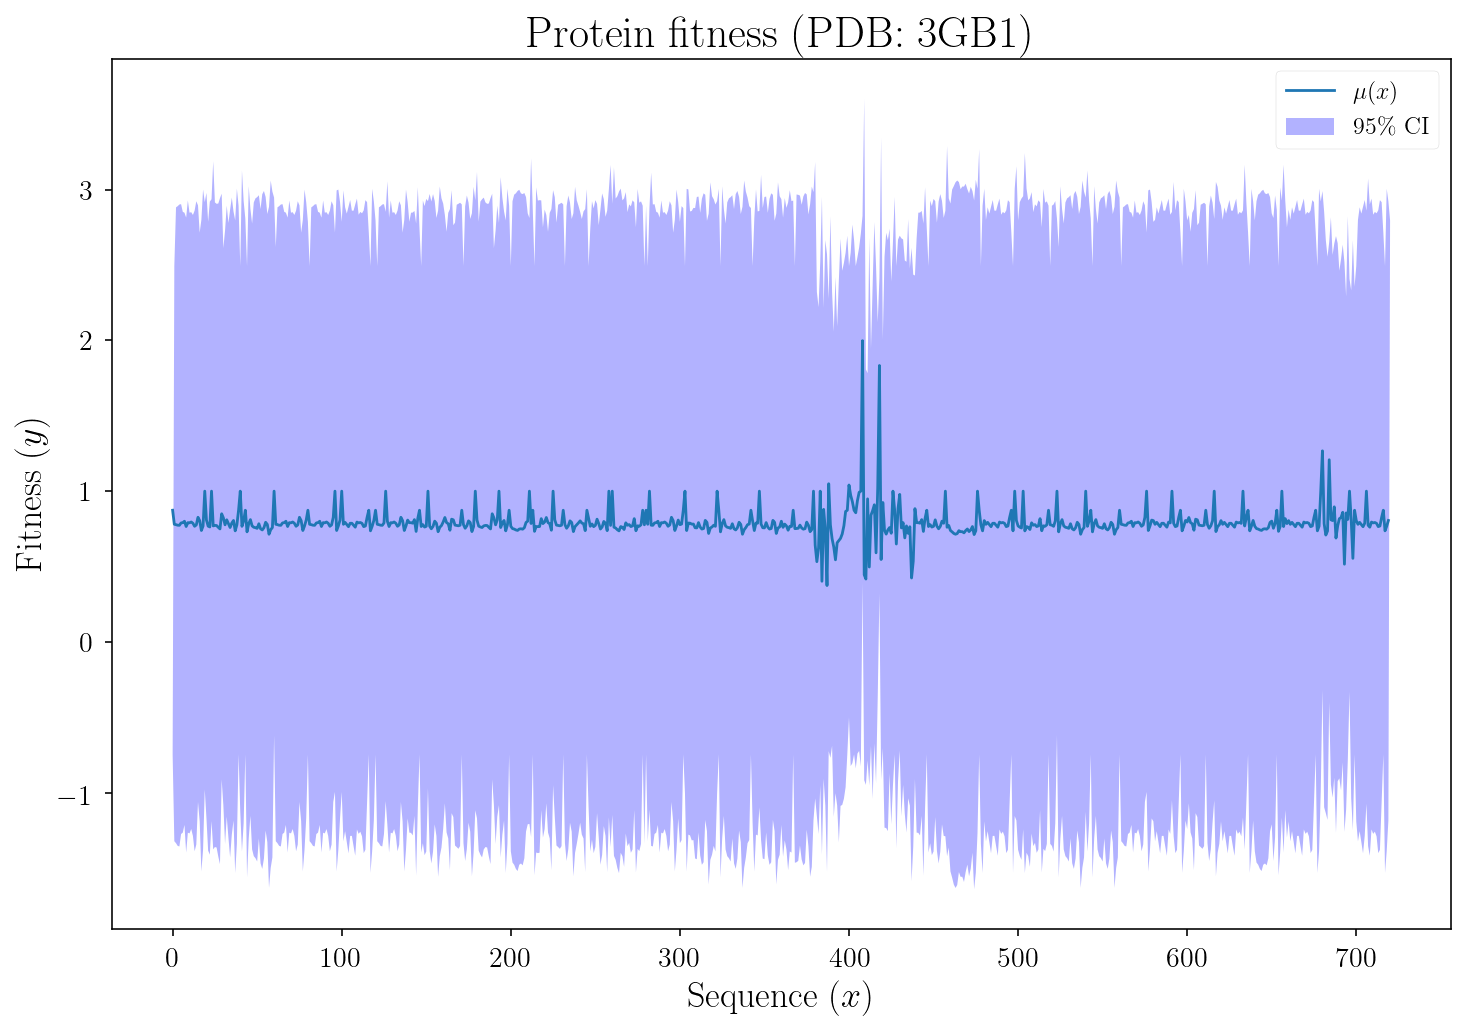

In [47]:
plt.figure(figsize=(12,8))
plt.plot(mean, label="$\mu(x)$")
plt.fill(np.concatenate([torch.arange(sigma.size(0)), torch.arange(sigma.size(0), 0, -1)]),
         np.concatenate([mean - 1.96 * sigma, torch.flip(mean + 1.96 * sigma, dims=(0,))]),
         alpha=0.3, fc="b", ec="None", label=r"95\% CI")
plt.xlabel("Sequence ($x$)")
plt.ylabel("Fitness ($y$)")
plt.legend()
plt.title("Protein fitness (PDB: 3GB1)")

In [48]:
means = mean.view(num_mutation_sites, vocab_size)
# # TODO: Impute WT sequences to have fitness=1???
# means[torch.floor(wt_pos_idx).long(), torch.floor(wt_aa_idx).long()] = 1.
# sns.heatmap(means, square=True, cmap="coolwarm")

In [ ]:
topk = 5
max_pos = torch.max(means, dim=-1) # max value per position
# Sort in descending order so numbers can be displayed properly
topk_pos_idx = torch.sort(max_pos.values, descending=True).indices[:topk]
topk_aa_idx = max_pos.indices[topk_pos_idx]
topk_vals = max_pos.values[topk_pos_idx]

# Create (numbered) annotation labels
topk_labels = torch.zeros_like(means).long()
topk_labels[topk_pos_idx, topk_aa_idx] = torch.arange(1, topk_pos_idx.size(0)+1)

# Create (wildtype) annotation labels
template = list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE")
Xaa_wt = torch.Tensor(preprocessor.get_input_feats(template))
wt_pos_idx = torch.arange(len(positions)).float()
wt_aa_idx = Xaa_wt[positions]
# Workaround: adjust positions so that scatter points are centered on heatmap 
wt_pos_idx += 0.5
wt_aa_idx += 0.5

In [ ]:
# NOTE: we add 1 to index since python index starts at 0, TODO: Check as this might be wrong!!!
df = pd.DataFrame(means.numpy(), index=positions+1, columns=seqs).rename_axis(
    "VP Position", axis="index").rename_axis("Amino Acid", axis="columns")
df.head()

In [ ]:
plt.figure(figsize=(12,12))
# Plot topk labels on top of other mutations so that numbers can be displayed
ax = sns.heatmap(df, cmap="coolwarm", square=True)
ax = sns.heatmap(df, cmap="coolwarm", square=True, annot=topk_labels, fmt="d",
            mask=(topk_labels==0).numpy(), cbar=False)
# Highlight topk sequences (w/ bbox)
for pos_idx, aa_idx in zip(topk_pos_idx.numpy(), topk_aa_idx.numpy()):
    ax.add_patch(plt.Rectangle(xy=(aa_idx, pos_idx), width=1, height=1,
                               fill=False, edgecolor='black', lw=1.0))
# Denote WT amino acid (w/ points)
plt.scatter(wt_aa_idx, wt_pos_idx, marker='o', color='black')

In [30]:
# FOR NOW, THIS DOESN't MATTER SO MUCH, we can optimize how the
# plot works later when we finalize the above results....
# Allow user to add bbox, topk sequences, impute WT with fitness=1, etc...
def mutation_heatmap(template=list("MTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"),
                     positions=np.arange(20, 56), vocab="aa20"):
    wt = copy.deepcopy(template)
    num_mutation_sites = len(positions)
    seqs = generator.gen(n=1) # single-point mutations

    # Permute each position with amino acid
    preprocessor = LSTMPreprocessor(vocab=vocab)
    all_seqs = []
    for pos in positions:
        for seq in seqs:
            template = wt
            template[pos-1] = seq
            all_seqs.append(preprocessor.get_input_feats(template))
    all_seqs = torch.Tensor(all_seqs).long()

    # Convert to onehot
    S = torch.zeros(*all_seqs.size(), vocab_size)
    S.scatter_(2, torch.unsqueeze(all_seqs, dim=2), 1)

    # Evaluate on (g-mean) oracle to get predictions
    gmean_oracle = all_oracles["g-mean"]
    gmean_oracle.eval()
    with torch.no_grad():
        y_pred = gmean_oracle(S)
        mean, sigma = y_pred[:,0], torch.sqrt(y_pred[:,1])

So the position 39,40 is the most informative since most amino acid substitutions result in a higher fitness score than the rest. But this only takes into account 1 mutation position. As we add more mutations, the effects of multi-site mutation is not additive, but rather becomes closer and closer to random as the mutation sites increase.

Show that oracle with designed is better than oracle that leads you astray into unknown regions, one using the DbAS weights? This might be an interesting since how do we plot the sequences that have been lead astray?

# Trajectory (along sequence space)